In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import coint

from matplotlib import rcParams
import cufflinks as cf
import yfinance as yf
import plotly.express as px


In [26]:
def ZScore(data):
    return (data - data.mean())/data.std()

In [27]:
def dynamicZScore(data, short, long):
    short_mean_df = data.rolling(short).mean()
    long_mean_df = data.rolling(long).mean()
    long_std_df=data.rolling(long).std()
    return (short_mean_df - long_mean_df)/long_std_df

## Strategy Presentation

We will implement a Long/Short investment strategy from a purely quantitative perspective. 

Long Short equity is an investing strategy taking long positions in stocks that are expected to appreciate and short positions in stocks that are expected to decline. 

## Cointegration: Introduction

- <u>Definition:</u> Cointegration __defines a strong relationship between two time series__. We will say that two variables are cointegrated if __they increase or decrease synchronously and steadily over time.__

- Stationarity: Statistical properties of a time series do not change over time (mean and variance are constant). 

- Order of integration: Summary statistic used to describe a time series. Specifically, it tells you __the minimum number of differences needed to get a stationary series. 

- An $I(1)$ series is differenced once to be stationary. 

__Price rate and yield data are $I(1)$ series, while returns can be assumed as stationary.__

Therefore, the behaviour of stationary series is predictable up to a certain point. 

But is the returns that are stationary, not the prices. However, __perhaps we can use stationarity with two assets instead of just one, and this is where the definition of cointegration comes into play.__

## Cointegration: Definition

$x_t$ and $y_t$ are cointegrated if $x_t$ and $y_t$ are $I(1)$ series and $\exists \beta$ such that: 

$$z_t = x_t - \beta y_t \text{ is an } I(0) \text{ series}$$

__Cointegration allows us to build a stationary series from two integrated series of order $1$ (as asset prices)__. 

As $z_t$ is stationary, the mean of the spread is not sensitive to the passage of time, therefore __one asset cannot be excessively overpriced for a long period of time wrt the other one__. 

Litterature advices to perform cointegration analysis in log prices instead of absolute prices (preferable in terms of interpretation).

Therefore we will bet on the stationary nature of 

$$log(y_t) - \beta log(x_t)$$

<u>Strategy:</u>

- If this difference is underpriced we will go long $y$ and short $x$

- Conversely if the difference is overpriced wrt historical mean. 

As with all hypothesis in statistics this must be tested, for cointegration we will use __the augmented Engle-Granger two step cointegration test.__

## How to test cointegration?

Step 1: Estimate the long-run equilibrium equation. 

To test this we will test if the error term in the linear regression

$$y_t = \mu + \beta x_t + \epsilon_t$$

Is stationary or not. 

To test this we will perform an __Augmented Dickey-Fuller test__

Step 2: Estimate the error correction model

Here we will estimate if, in the following equation

$$\Delta y_t = \phi_0 + \phi_1\Delta y_{t-1} + \theta_1\Delta x_{t-1} + \alpha (y_{t-1} - \hat{\delta}_0 - \hat{\delta}_1x_{t-1}) + \epsilon_t$$

If the coefficient $\alpha$ is negative. This means that whenever the deviation from equilibrium os negative, then $\alpha$ will bring it back. 

## Visualization

In order to put in practice what have been explained above, we are going to study two time series known for their joint evolution. These are WTI Crude Oil and Brent Crude Oil. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


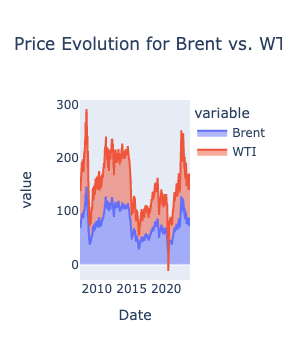

In [4]:

cf.set_config_file(theme='white',offline=True)
df = pd.DataFrame(columns = ["Brent", "WTI"])
df["Brent"]= yf.download("BZ=F")["Close"]
df["WTI"]= yf.download("CL=F")["Close"]

fig = fig = px.area(
    df, 
    title = "Price Evolution for Brent vs. WTI as of 06/06/23")


fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)


Indeed, except for some major disjuncture such as mid-2020 where the WTI price fell below to 0 due to lack of demand and storage space for the product, it seems that these two assets are indeed evolving in sync. 

Let us now show a correlation chart on a 30D lookback basis. 

In [5]:
df_correlation = pd.DataFrame(columns = ["Correlation"])
df_correlation["Correlation"] = (df['Brent'].rolling(30).corr(df['WTI']).dropna() *100).round(1)
df_correlation.max()

Correlation    99.9
dtype: float64

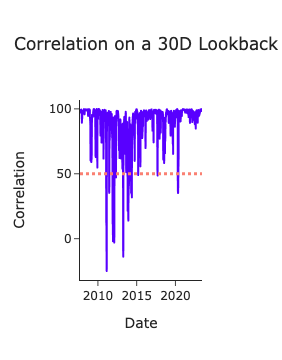

In [6]:
fig = px.line(df_correlation,
              y = "Correlation",
             title = "Correlation on a 30D Lookback Window",
             template = "simple_white"
             )
fig['data'][0]['line']['color']='#5800FF'
fig['data'][0]['line']['width']=2
fig.add_shape(type = "line",
              line_color = "salmon",
              line_width = 3,
              line_dash = "dot",
              opacity = 1, 
              x0 = 0,
              x1 = 1, 
              xref = "paper",
              y0 = 50, 
              y1 = 50, 
              yref = "y"
             )
fig.show()

Now, just to visualize it, let's get a quick look at the logarithm of these two assets. 

<AxesSubplot:xlabel='Date'>

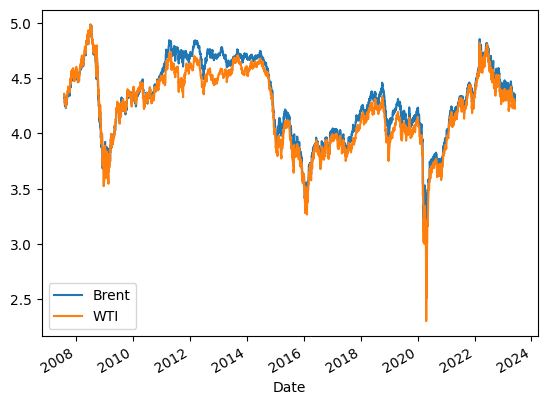

In [9]:
df_correlation.mean()
mask = np.logical_and(df["Brent"] > 0, df["WTI"] > 0 )
log_price = np.log(df[mask])
log_price.plot()

We will use the Python library __stattools__ to test for cointegration on the logarithm of the prices. 

In [10]:
eg_test = engle_granger(log_price["Brent"], log_price["WTI"], trend = "n")
eg_test

Test Statistic,-5.044
P-value,0.000
ADF Lag length,5
Estimated Root ρ (γ+1),0.983


On the first step of the EG cointegration test we obtain that these two time series are cointegrated with more than a 99% confidence. 

So it seems that long-term relationship holds, let's __plot the residuals of the linear regression tested to see if it evolves around an average of 0__. 

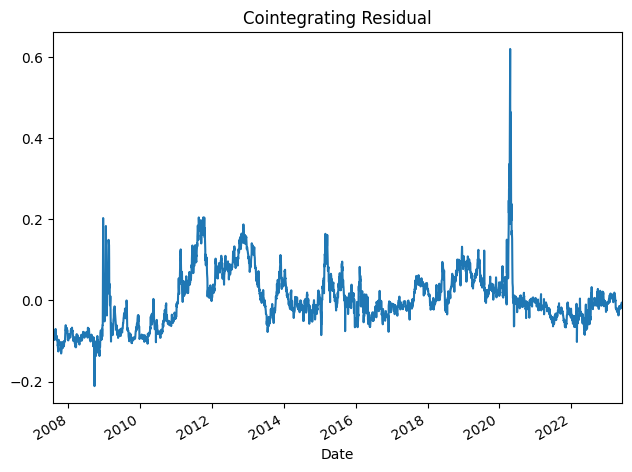

In [11]:
fig = eg_test.plot()

Now let us perform the second step of the cointegration test. 

In [62]:
t = coint(log_price["Brent"], log_price["WTI"])[0]
p = coint(log_price["Brent"], log_price["WTI"])[1]
k = coint(log_price["Brent"], log_price["WTI"])[2]
print(f"T-statistic: {t} and p-value: {p} key values: {k}")

T-statistic: -3.635001773286012 and p-value: 0.022161109854894976 key values: [-3.89937621 -3.33776727 -3.04558633]


Thus, we can state with 98% confidence that these two time series are cointegrated. 

## Using Cointegration in Trading: Pair Trading Strategy 

In this section we will perform a trading strategy which involves matching a long position with a short position in two stocks with a robust statistical relationship (in our case cointegration).

This is what is known as a statistical arbitrage strategy, i.e., we use a statistical relationship between two assets that is robust over time, in this case cointegration, in order to take advantage of it. 

Once we have a pair of stocks that are cointegratef we will go long on the underperforming asset and short the other one. __If securities return to their historical cointegration, a profit is made from convergence__. 

Suppose we have a pair of securities such that log-prices X and Y are cointegrated, this they follow: 

$$y_t - \beta x_t = \mu + \epsilon_t$$

Therefore, we will make a profit on the log-spread reverting to its mean. In order to do this we will watch for X and Y being far apart, i.e, when spread is too high or too low: 

- Going Long the Spread: When log-spread is smaller than usual. Buy Y and sell X. 
- Going short the Spread: When the spread is too large. Buy X. 

## Implementing the strategy

We will use S&P 500 stocks belonging to the same sector. We look at a particular sector as this increases the chances of finding cointegrated pairs saving us a lot of computational time. 

We have chosen the financial sector, to be more precise, __asset managers, diversified and investment banks.__

In [12]:
ticker_list = pd.read_html(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df_ticker = ticker_list[0]
df = df_ticker[df_ticker["GICS Sector"] == "Financials"]
df.head(50)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
11,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
21,ALL,Allstate,Financials,Property & Casualty Insurance,"Glenview, Illinois",1995-07-13,899051,1931
31,AXP,American Express,Financials,Consumer Finance,"New York City, New York",1976-06-30,4962,1850
32,AIG,American International Group,Financials,Property & Casualty Insurance,"New York City, New York",1980-03-31,5272,1919
35,AMP,Ameriprise Financial,Financials,Asset Management & Custody Banks,"Minneapolis, Minnesota",2005-10-03,820027,1894
42,AON,Aon,Financials,Insurance Brokers,"London, UK",1996-04-23,315293,1982 (1919)
47,ACGL,Arch Capital Group,Financials,Reinsurance,"Hamilton, Bermuda",2022-11-01,947484,1995
49,AJG,Arthur J. Gallagher & Co.,Financials,Insurance Brokers,"Rolling Meadows, Illinois",2016-05-31,354190,1927
50,AIZ,Assurant,Financials,Multi-line Insurance,"New York City, New York",2007-04-10,1267238,1892
60,BAC,Bank of America,Financials,Diversified Banks,"Charlotte, North Carolina",1976-06-30,70858,1998 (1923 / 1874)


In [13]:
mask = np.logical_or(df["GICS Sub-Industry"] == 'Investment Banking & Brokerage', np.logical_or(df["GICS Sub-Industry"] =='Asset Management & Custody Banks', df["GICS Sub-Industry"] =='Diversified Banks'))
df.reset_index()
df = df[mask]

In [14]:
df.reset_index(drop = True, inplace = True)
df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,AMP,Ameriprise Financial,Financials,Asset Management & Custody Banks,"Minneapolis, Minnesota",2005-10-03,820027,1894
1,BAC,Bank of America,Financials,Diversified Banks,"Charlotte, North Carolina",1976-06-30,70858,1998 (1923 / 1874)
2,BLK,BlackRock,Financials,Asset Management & Custody Banks,"New York City, New York",2011-04-04,1364742,1988
3,BK,BNY Mellon,Financials,Asset Management & Custody Banks,"New York City, New York",1995-03-31,1390777,1784
4,SCHW,Charles Schwab Corporation,Financials,Investment Banking & Brokerage,"Westlake, Texas",1997-06-02,316709,1971
5,C,Citigroup,Financials,Diversified Banks,"New York City, New York",1988-05-31,831001,1998
6,CMA,Comerica,Financials,Diversified Banks,"Dallas, Texas",1995-12-01,28412,1849
7,BEN,Franklin Templeton,Financials,Asset Management & Custody Banks,"San Mateo, California",1998-04-30,38777,1947
8,GS,Goldman Sachs,Financials,Investment Banking & Brokerage,"New York City, New York",2002-07-22,886982,1869
9,IVZ,Invesco,Financials,Asset Management & Custody Banks,"Atlanta, Georgia",2008-08-21,914208,1935


For each pair of stocks, we will compute the results of the two-step Engle-Granger test and display the results in a heatmap. The pairs with a p-value of less than 5% can be seen below:

In [15]:
tickers = df["Symbol"].tolist()

In [120]:
df_log = yf.download(tickers, start= "2010-01-01")["Close"].apply(lambda x: np.log(x))
df_actual =yf.download(tickers, start= "2010-06-01")["Close"]

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  18 of 18 completed


In [121]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            df = pd.concat([S1, S2], axis = 1).dropna(how = "any")
            result = coint(df[df.columns[0]], df[df.columns[1]])
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], round(pvalue, 2)))
    return score_matrix, pvalue_matrix, pairs

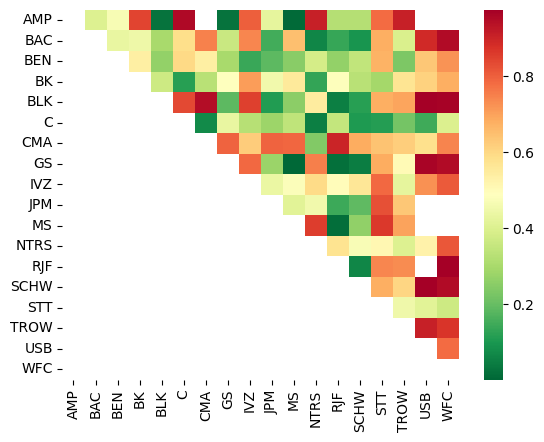

[('AMP', 'BLK', 0.03), ('AMP', 'GS', 0.03), ('AMP', 'MS', 0.01), ('BLK', 'RJF', 0.05), ('C', 'NTRS', 0.05), ('GS', 'MS', 0.0), ('GS', 'RJF', 0.02), ('GS', 'SCHW', 0.04), ('MS', 'RJF', 0.01)]


In [122]:
scores, pvalues, pairs = find_cointegrated_pairs(df_log)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(
    pvalues,
    xticklabels=df_log.columns.tolist(), 
    yticklabels=df_log.columns.tolist(),
    cmap='RdYlGn_r',
    mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

Looks like __Ameriprise(AMP) and Morgan Stanley (MS) are cointegrated__. 

0.006944277405766021


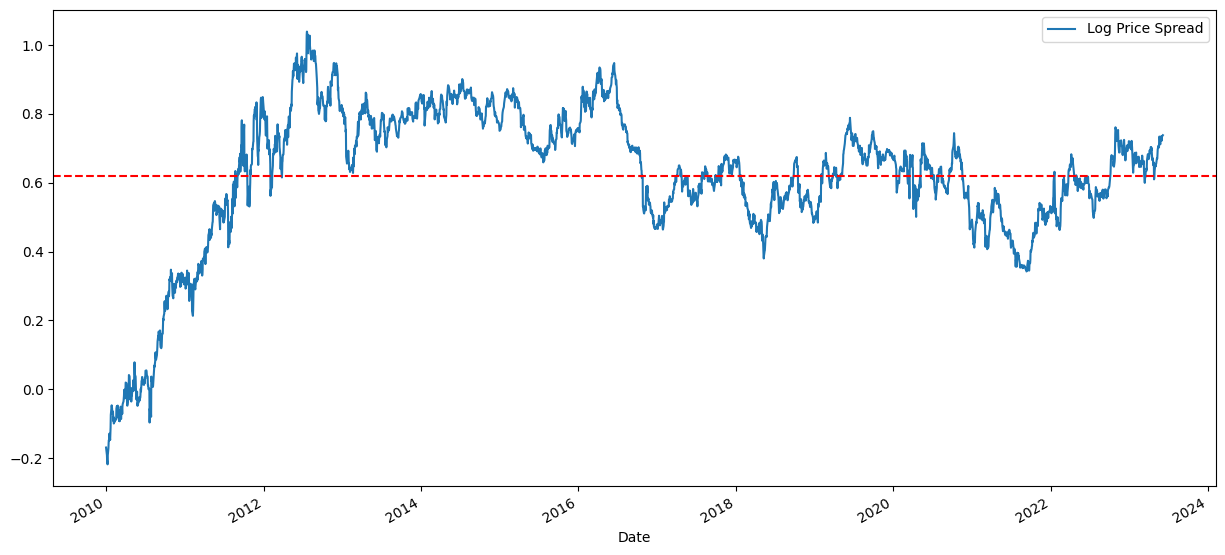

In [123]:
S1 = df_log['AMP']
S2 = df_log['MS']
df = pd.concat([S1, S2], axis = 1).dropna(how = "any")
score, pvalue, _ = coint(df[df.columns.tolist()[0]], df[df.columns.tolist()[1]])
print(pvalue)
ratios = S1 - 1.13*S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean(), color = "red", linestyle = "--")
plt.legend(['Log Price Spread'])
plt.show()

Indeed, since 2020 it seems that log-spread has stabilized. 

Therefore we have already chosen two stocks that appear to be cointegrated, whose difference in logarithm terms evolves around a constant mean, with constant levels of deviation from the mean. 


## Defining entry and exit points (static case)

How to define the concept of log-sprad (or ratio) distance to the mean in quantitative terms?

For this purpose we will use the __Z-Score__ concept, which is basically a metric describing a value's distance to the mean in terms of standard deviation. A Z-Score of 1 would indicate a value that is one standard deviation from the mean. 

For our price ratio $r_t$, historical ratio mean of $\mu$ and standard deviation of $\sigma$, we have the following formula:

$$Z(r_t) = \frac{r_t - \mu}{\sigma}$$

Therefore a very simple trading strategy can be to look at the Z-Score of the ratio of the two chosen stocks and interpret it as follows:

- If it's greater than 1 it means that the price ratio is overpriced. We will buy the asset "in the numerator" (BEN) and sell the one "in the denominator" (BK). 

- Conversely if the Z-Score is less than 1. 

- Exit positions whenever the Z-Score approaches to 0. 

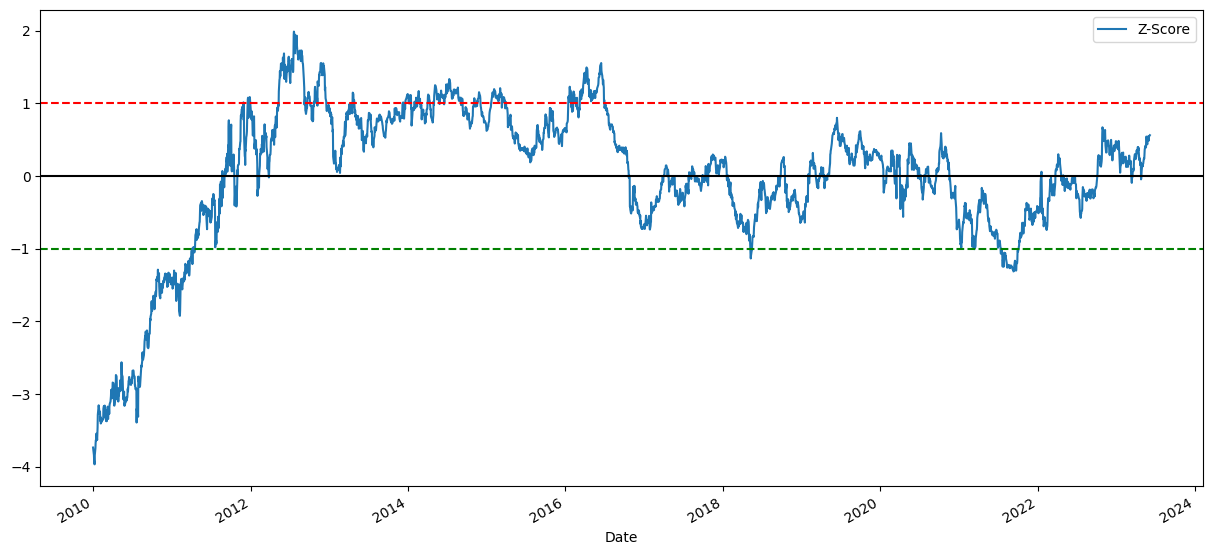

In [124]:
splitting_year = 2018
train_df = df_actual[df_actual.index.year <= splitting_year]
test_df = df_actual[df_actual.index.year > splitting_year]
ratios_train = train_df.loc[: , "AMP"]/train_df.loc[: ,"MS"]
ratios_test = test_df.loc[: , "AMP"]/test_df.loc[: ,"MS"]
df_Z = ZScore(ratios)
df_Z.plot(figsize=(15,7))
plt.axhline(-1, color = "green", linestyle = "--")
plt.axhline(0, color = "black", linestyle = "-")
plt.axhline(1, color = "red", linestyle = "--")
plt.legend(['Z-Score'])
plt.show()

However, this strategy is not very dynamic and flexible since we depend on the mean and the historical standard deviation of the ratio. Better to use entry and exit points that are better adapted to a dynamic market.  

## Defining entry and exit points (dynamic case)

In general, taking statistics over the whole sample size can perform poorly. For example, if the market is moving up, and both securities with it, then your average price over the last 5 years may not be representative of today. __We will define statistics that rely on rolling windows of the most recent data.__

Instead of using historical statistics, use 5 days and 60 days moving average as replacements for the mean and standard deviation. 

We will name our new metric __dynamic Z-Score__:

$$Z(r_t) = \frac{MA(5) - MA(60)}{MSTD(60)}$$

Here is a graph showing the evolution of this metric from 2010 to nowadays. 

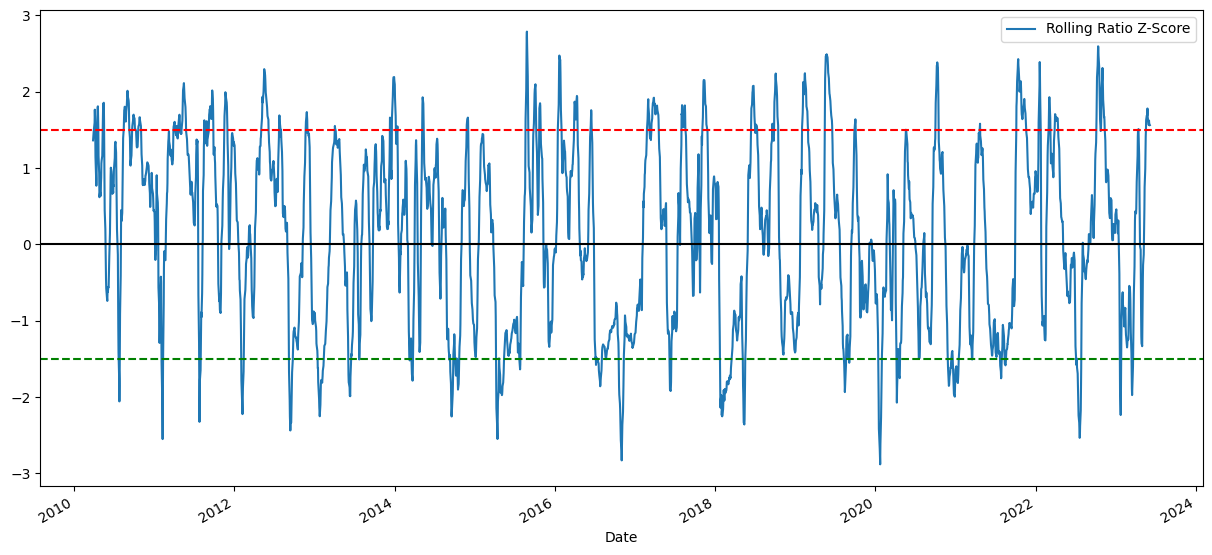

In [126]:
df_dynamic_Z = dynamicZScore(ratios, 5, 60)
df_dynamic_Z.plot(figsize=(15,7))
plt.axhline(-1.5, color = "green", linestyle = "--")
plt.axhline(0, color = "black", linestyle = "-")
plt.axhline(1.5, color = "red", linestyle = "--")
plt.legend(['Rolling Ratio Z-Score'])

This ratio seems much more stable and solid that the static Z-Score defined in last section. 

However, this dynamic Z-Score does not make much sense on its own , let us look at the buy and sell signals over price ratio. 

Below the buy and sell signals plotted with the price ratio.

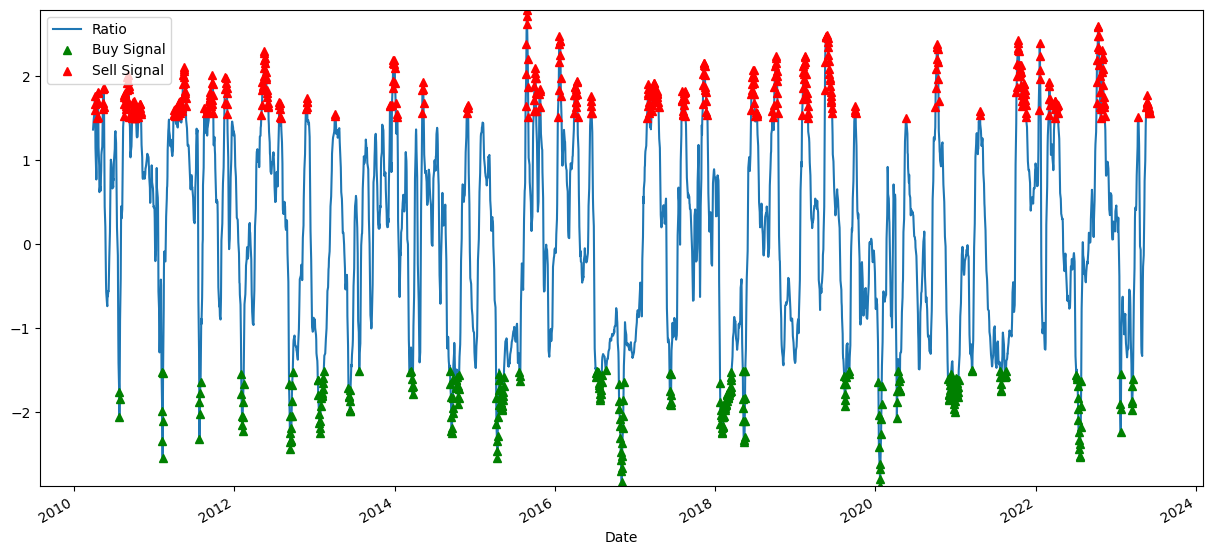

In [127]:
plt.figure(figsize=(15,7))

df_dynamic_Z.plot()
buy = df_dynamic_Z.copy()
sell = df_dynamic_Z.copy()
buy[df_dynamic_Z>-1.5] = -1000
sell[df_dynamic_Z<1.5] = -1000
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,df_dynamic_Z.min(),df_dynamic_Z.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

What does it mean for the actual stocks we are trading in our training dataframe? Here we will se the data from 2018 to nowadays. 

[*********************100%***********************]  18 of 18 completed


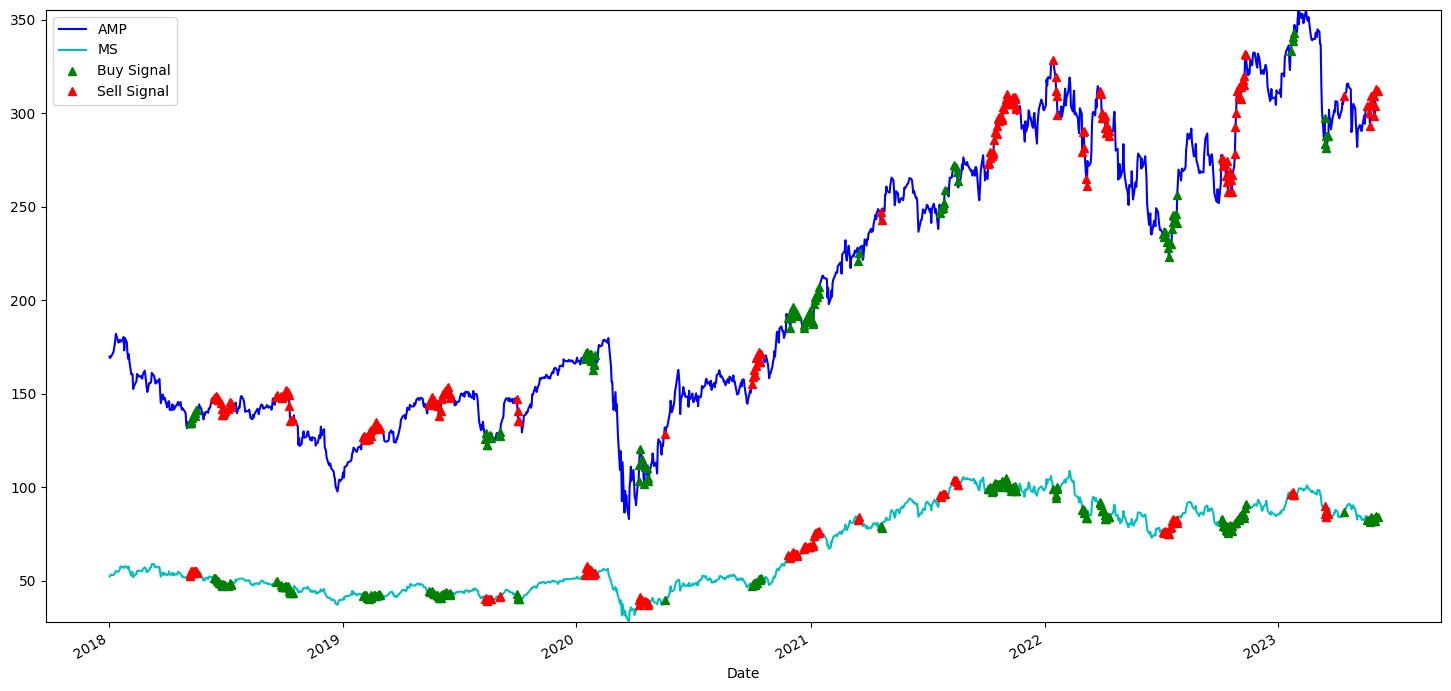

In [131]:
plt.figure(figsize=(18,9))
df_actual_new =yf.download(tickers, start= "2018-01-01")["Close"]
S1 = df_actual_new.loc[:, 'AMP']
S2 = df_actual_new.loc[:, 'MS']

S1.plot(color='b')
S2.plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=-1000] = S1[buy!=-1000]
sellR[buy!=-1000] = S2[buy!=-1000]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=-1000] = S2[sell!=-1000]
sellR[sell!=-1000] = S1[sell!=-1000]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['AMP','MS', 'Buy Signal', 'Sell Signal'])
plt.show()

The dataframe is divided in two so that we can choose the length of the long-term moving average window optimally according to the assets you are dealing with. 

For this __we splitted the dataset in 2__.

- Training dataframe: analyze the combination of short term and long term periods and choosing the one with the best PnL. (From 2010 to 2018). 

- Testing dataframe: How this parameter choice behaves on new data, avoiding overfitting. (From 2018 onwards). 

For the method we will write a simple backtester:

- Buy 1 ratio (buy 1 AMP stock and sell ratio x MS stock) when dynamic Z-Score is below -1.5.

- Sell 1 ratio when dynamic Z-Score is above 1.5. 

- Exit all positions when dynamic Z-Score is below 0.5. 

- No money at the start of the trading period.

- No transaction costs.

In [132]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    PnL = []
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        PnL.append(money)
        # Sell short if the z-score is > 1
        if zscore[i] > 1.5:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1.5:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0

    return money, PnL

Now, we will search the best long-term window (short-term window will be fixed at 5 days, one next step could be to also choose a better short-term window).


In [161]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
train_scores = []
windows = []
for long in range(1, 150):
        total = trade(train_df.loc[:, 'AMP'], train_df.loc[:, 'MS'], 5, long)
        train_scores.append(total[0])
        windows.append(long)
best_length_train = np.argmax(train_scores)
print(f"Best Profits:", train_scores[best_length_train])
print(f"Best Window:", windows[best_length_train])

Best Profits: 1821.8844256707832
Best Window: 144


So, __the best choice is 144 days for the long-term window.__

In [165]:
test_scores = []
windows = []
for long in range(1, 150):
        test_scores.append(trade(test_df.loc[:, 'AMP'], test_df.loc[:, 'MS'], 5, 144)[0])
        windows.append(long)
best_length_test = np.argmax(test_scores)
print(f"Best Profits:", test_scores[best_length_test])
print(f"Best Window:", windows[best_length_test])

Best Profits: 2646.9815771849235
Best Window: 1


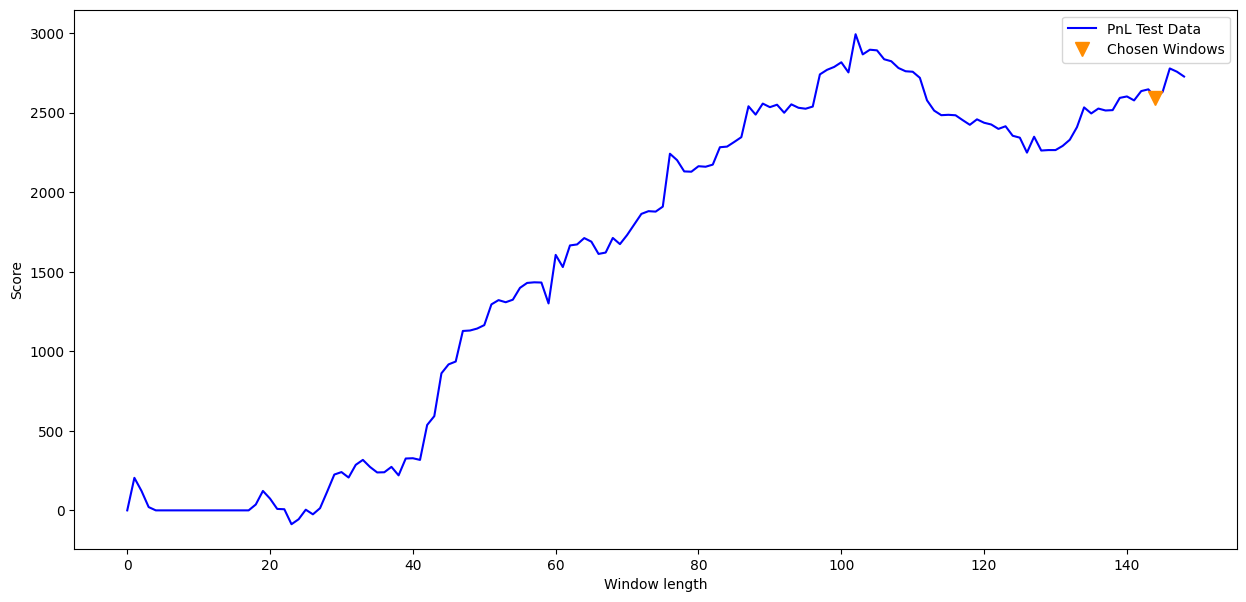

In [164]:
plt.figure(figsize=(15,7))
#plt.plot(train_scores)
plt.plot(test_scores, color = "blue")
#plt.plot([windows[best_length_train]], [train_scores[best_length_train]], 'v', color='red', ms=10)
plt.plot(144, [test_scores[144]], 'v', color='darkorange', ms=10)
#plt.plot(137, [test_scores[137]], 'v', color='darkorange', ms=10)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['PnL Test Data', 'Chosen Windows'])
plt.show()

Thus using the parameter choice from training dataframe, we managed to make 2646 USD on testing dataframe data (and our simplified backtester.)